<font size = 6> Проверка гипотез увеличения выручки интернет-магазина </font>

## Описание проекта

Совместно с отделом маркетинга подготовлен список гипотез для увеличения выручки.

**Задачи:**
- приоритизация гипотез; 
- анализ результатов A/B-теста

**Описание данных**

Файл hypothesis.csv - гипотезы по увеличению выручки интернет-магазина
* Hypothesis — краткое описание гипотезы;
* Reach — охват пользователей по 10-балльной шкале;
* Impact — влияние на пользователей по 10-балльной шкале;
* Confidence — уверенность в гипотезе по 10-балльной шкале;
* Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

Файлы orders.csv, visitors.csv - результаты  A/B-теста  
orders.csv
* transactionId — идентификатор заказа;
* visitorId — идентификатор пользователя, совершившего заказ;
* date — дата, когда был совершён заказ;
* revenue — выручка заказа;
* group — группа A/B-теста, в которую попал заказ.  

visitors.csv
* date — дата;
* group — группа A/B-теста;
* visitors — количество пользователей в указанную дату в указанной группе A/B-теста

## Получение данных

In [1]:
# Импорт необходимых библиотек
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

In [2]:
# создадим список с именами тадлиц для чтения
files_list = ['hypothesis', 'orders', 'visitors']

# ссылка для файлов на Яндексе
link_to_files = '**************************'

In [3]:
# читаем данные и выводим название, info и первые 2 строки
for file_name in files_list:
    
    try:
        globals()[file_name] = pd.read_csv(file_name + ".csv")
    except Exception as e:
        print(f'{e} Локальная версия файла не найдена. Загрузка с ЯП')
        globals()[file_name] = pd.read_csv(link_to_files + file_name + ".csv")
    
    print(50*'>', file_name)
    globals()[file_name].info()
    display(globals()[file_name].head(2))
    print()

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> hypothesis
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10



>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> orders
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B



>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> visitors
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619


In [4]:
# посмотрим распределение по группам
visitors.groupby('group').agg({'visitors':'sum'})

,visitors
group,
A,18736
B,18916


In [5]:
# посмотрим на выручку по группам
orders.groupby('group').agg({'revenue':'sum'})

,revenue
group,
A,4084803
B,5907760


In [6]:
# посмотрим распределение по группам
visitors.groupby('group').agg({'visitors':'count'})

,visitors
group,
A,31
B,31


In [7]:
# посмотрим на число заказов и выручку по группам 
(
orders.groupby('group')
    .agg({'transactionId':'count', 'revenue':'sum'})
    .rename(columns={'transactionId': 'orders', 'revenue': 'total_revenue'})
)    

,orders,total_revenue
group,,
A,557,4084803
B,640,5907760


In [8]:
# проверим число дубликатов в таблицах
print(f'Число дубликатов в таблице orders   - {orders.duplicated().sum()}')
print(f'Число дубликатов в таблице visitors - {visitors.duplicated().sum()}')

Число дубликатов в таблице orders   - 0
Число дубликатов в таблице visitors - 0


In [9]:
# посмотрим на число пересечений, т.е. число visitorId попавших в обе группы
id_repeats = len(pd.merge(orders[orders['group'] == 'A']['visitorId'].drop_duplicates(),
                          orders[orders['group'] == 'B']['visitorId'].drop_duplicates(),
                          how='inner',
                          on='visitorId',
                         )
                )
print(f'Число клиентов попавших в обе группы - {id_repeats}')

Число клиентов попавших в обе группы - 58


Дубликаты не выявлены. Наличие пересечений учтём ниже при установлении гриниц аномальности.

## Приоритизация гипотез

In [10]:
# Посмотрим на таблицу с гипотезами
pd.set_option('display.max_colwidth', 0)
hypothesis

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


### Фреймворк ICE

In [11]:
# Применим фреймворк ICE для приоритизации гипотез
hypothesis['ICE'] = hypothesis['Impact'] * hypothesis['Confidence'] / hypothesis['Efforts']

hypothesis.sort_values(by='ICE', ascending=False)

,Hypothesis,Reach,Impact,Confidence,Efforts,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.200000
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.333333
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.200000
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.000000
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.000000
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.000000
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.333333
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.125000
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.000000


Наиболее перспективные гипотезы по ICE: 8, 0, 7

### Фреймворк RICE

In [12]:
# Применим фреймворк RICE для приоритизации гипотез
hypothesis['RICE'] = hypothesis['Reach'] * hypothesis['Impact'] * hypothesis['Confidence'] / hypothesis['Efforts']

hypothesis.sort_values(by='RICE', ascending=False)

,Hypothesis,Reach,Impact,Confidence,Efforts,ICE,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.200000,112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.000000,56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.333333,40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.000000,40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.200000,16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.125000,9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.000000,4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.333333,4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.000000,3.0


При расчете RICE гипотеза 8 опустилась на 5-ое место в то время как на первое поднялась гипотеза 7. Это обусловлено учетом показателя охвата при расчёте RICE. Так охват для гипотезы 7 оценен в 10, а для гипотезы 8 только в 1.

In [13]:
print(f"Приоритетная гипотеза: {hypothesis.loc[7, 'Hypothesis']}")

Приоритетная гипотеза: Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок


## Анализ A/B-теста

Изменим формат данных

In [14]:
orders['date'] = orders['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))
visitors['date'] = visitors['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

### Кумулятивная выручка по группам

In [15]:
# создадим массив уникальных пар значений дата - группа теста
datesGroups = orders[['date','group']].drop_duplicates()

# кумулятивные данные о заказах 
ordersAggregated = ( 
    datesGroups.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])]
    .agg({'date' : 'max',
          'group' : 'max',
          'transactionId' : 'nunique',
          'visitorId' : 'nunique',
          'revenue' : 'sum'}), axis=1)
    .sort_values(by=['date','group'])
)

# кумулятивные данные о посетителях 
visitorsAggregated = (
    datesGroups.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])]
    .agg({'date' : 'max', 
          'group' : 'max', 
          'visitors' : 'sum'}), axis=1)
    .sort_values(by=['date','group'])
)

# объединим кумулятивные данные в одной таблице
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
# переименуем столбцы
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']
cumulativeData.head()

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,24,20,148579,719
1,2019-08-01,B,21,20,101217,713
2,2019-08-02,A,44,38,242401,1338
3,2019-08-02,B,45,43,266748,1294
4,2019-08-03,A,68,62,354874,1845


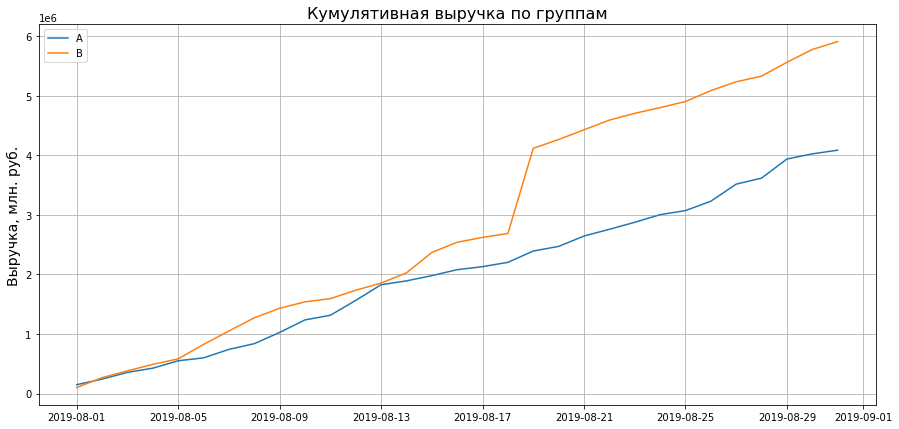

In [16]:
# разделим данные по группам
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date', 'revenue', 'orders']]
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date', 'revenue', 'orders']]

# строим графики
plt.figure(figsize=(15, 7))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')

plt.title(f'Кумулятивная выручка по группам', fontsize=16)
plt.grid(axis='both')
plt.ylabel("Выручка, млн. руб.", fontsize=14)

plt.legend()
plt.show()

**Выводы** Выручка по обеим группам растёт. В группе В, между 18 и 20 августом, имеет место резкий скачок. Вероятно, в указаное время имела место, либо необычно высокая активность всех польхователей, либо большой заказ.

### Кумулятивный средний чек по группам 

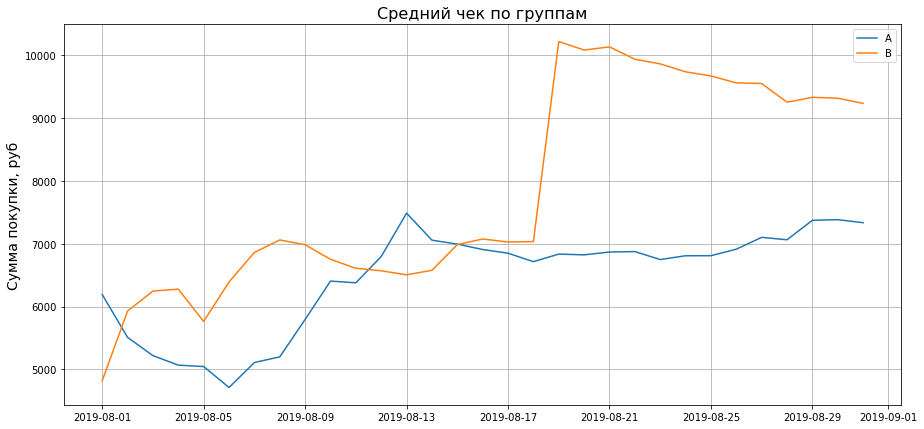

In [17]:
plt.figure(figsize=(15, 7))

# разделим кумулятивную выручку на кумулятивное число заказов
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')

plt.title(f'Средний чек по группам', fontsize=16)
plt.grid(axis='both')
plt.ylabel("Сумма покупки, руб", fontsize=14)
plt.legend()
plt.show()

**Выводы** В первой декаде средние чеки по группам А и В показывают разнонаправленное движение. Средний чек группы В здесь выше, различие до полутора тысяч. К середине месяца группы сходятся и средние чеки колеблются в районе 7000руб. Далее следуют резкий рост среднего чека группы В, обусловленный предположительно большим заказом. Во второй половине месяца средний чек группы А колеблется около 7000, а группы В - достигнув максимума в чуть более 10000 снизился на 1000 за примерно 10 дней.

### Относительное изменение кумулятивного среднего чека группы B к группе A

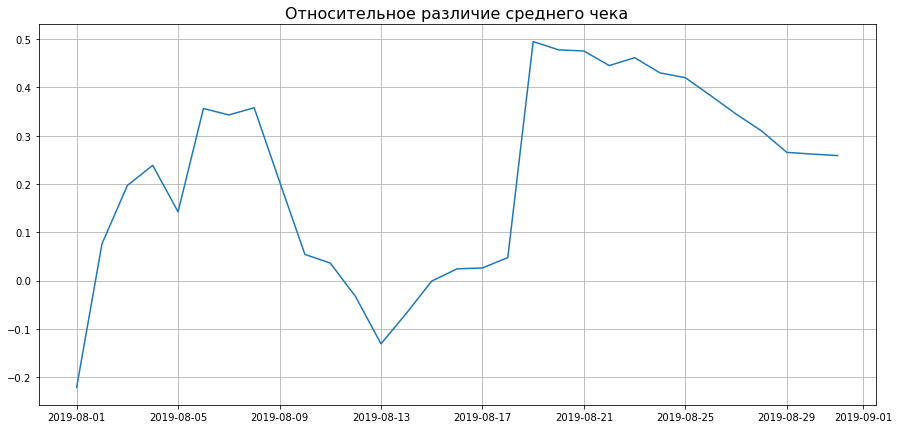

In [18]:
# объединим данные групп по кумулятивной выручке
mergedCumulativeRevenue = (
    cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B']))

# cтроим тграфик относительного различия
plt.figure(figsize=(15, 7))

plt.plot(
    mergedCumulativeRevenue['date'], 
    (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/
    (mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)

plt.title(f'Относительное различие среднего чека', fontsize=16)
plt.grid(axis='both')
plt.show()

**Выводы**  По полученному графику однозначно выделить какую-либо из групп затруднительно. Группа B, на рассмотриваемом интервал, в целом лучше группы A, но имеется провал и нисходящий тренд в третьей декаде.

### Кумулятивная конверсия по группам

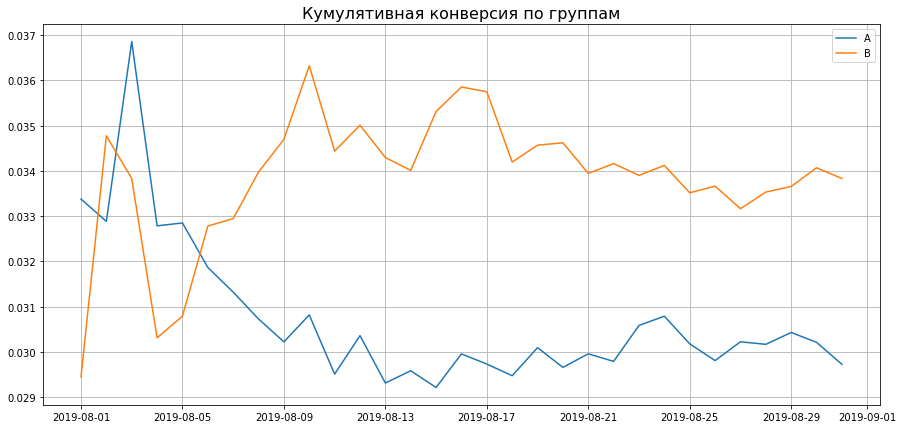

In [19]:
# считаем кумулятивную конверсию
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

# выделяем данные по группам A и В
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

# строим графики
plt.figure(figsize=(15, 7))
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')

plt.title(f'Кумулятивная конверсия по группам', fontsize=16)
plt.grid(axis='both')
plt.legend()

plt.show()

**Выводы** Конверсия группы В после незначительного колебания в начале, показывает лучший результат. Можно говорить, что конверсии зафиксировались около 0.034 и 0.030 для групп В и А соответсвенно.

### Относительное изменение кумулятивной конверсии группы B к группе A

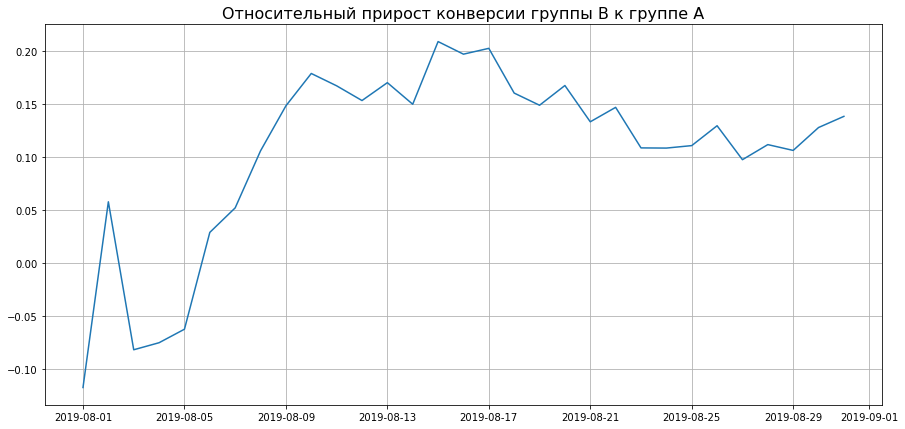

In [20]:
# объединим данные групп по кумулятивной конверсии
mergedCumulativeConversions = (
    cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']], 
                                                 left_on='date', 
                                                 right_on='date', 
                                                 how='left', 
                                                 suffixes=['A', 'B']))
plt.figure(figsize=(15, 7))

plt.plot(mergedCumulativeConversions['date'], 
         mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1
        )

plt.title(f'Относительный прирост конверсии группы B к группе A', fontsize=16)
plt.grid(axis='both')
plt.show()

**Выводы** В начале теста группа B проигрывала группе A, затем вырвалась вперёд. Потом её конверсия немного упала, а во второй половине месяца держится стабольно выше конверсии группа А.

### Количество заказов по пользователям

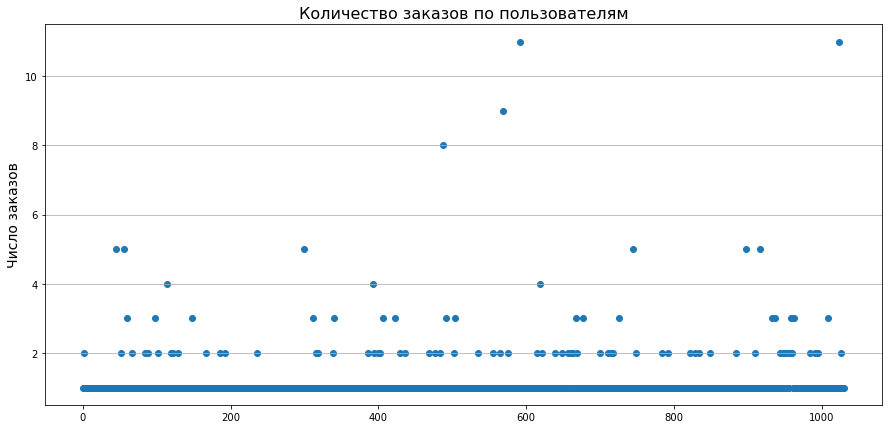

In [21]:
ordersByUsers = orders.groupby('visitorId', as_index=False).agg({'transactionId': 'nunique'})
ordersByUsers.columns = ['visitorId', 'orders']

x_values = pd.Series(range(0,len(ordersByUsers)))

plt.figure(figsize=(15, 7))
plt.scatter(x_values, ordersByUsers['orders']) 
plt.title(f'Количество заказов по пользователям', fontsize=16)
plt.ylabel("Число заказов", fontsize=14)
plt.grid(axis='y')
plt.show()

Посчитаем 95-й и 99-й перцентили количества заказов на пользователя и выберем границу для определения аномальных пользователей.

In [22]:
np.percentile(ordersByUsers['orders'], [95, 99])

array([2., 4.])

**Выводы** График показал, что ольшинство покупателей заказывали только один раз. Однако, есть 5% покупателей с более чем двумя заказами, а 1% сделали более 4 заказов. Для определения аномальных пользователей, в качестве границы, выберем 2 заказа.

### Стоимости заказов

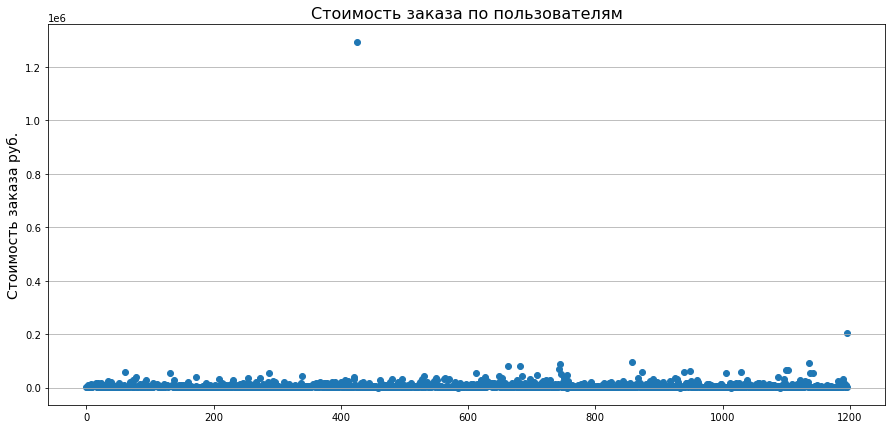

In [23]:
x_values = pd.Series(range(0,len(orders['revenue'])))

plt.figure(figsize=(15, 7))
plt.scatter(x_values, orders['revenue']) 
plt.title(f'Стоимость заказа по пользователям', fontsize=16)
plt.ylabel("Стоимость заказа руб.", fontsize=14)
plt.grid(axis='y')

plt.show()

In [24]:
# посмотрим на данный по максимальному заказу
orders.loc[orders['revenue'] == orders['revenue'].max()]

,transactionId,visitorId,date,revenue,group
425,590470918,1920142716,2019-08-19,1294500,B


Дата заказа: 19 августа  
Сумма заказа:  1 294 500  
Установлена причина резкого скачка выручки и среднего чека по группе В. Явная аномалия.

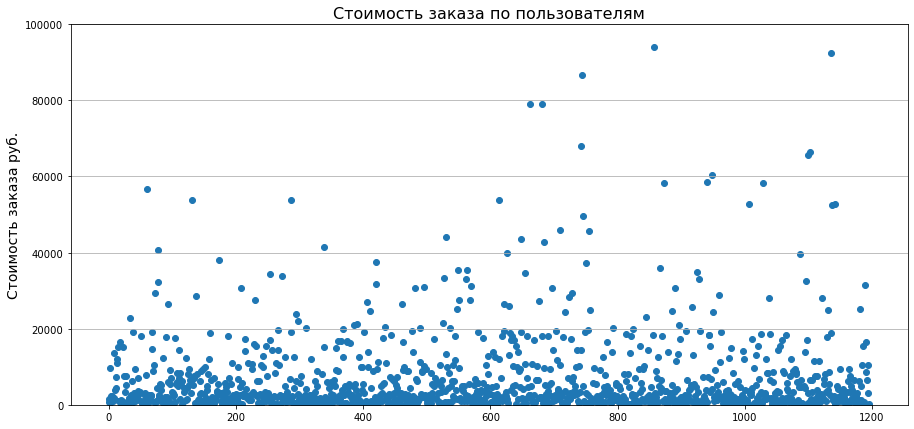

In [25]:
# выделим заказы с суммой до 10тыс.руб
plt.figure(figsize=(15, 7))
plt.scatter(x_values, orders['revenue']) 
plt.title(f'Стоимость заказа по пользователям', fontsize=16)
plt.ylabel("Стоимость заказа руб.", fontsize=14)
plt.grid(axis='y')
plt.axis(ymin=0, ymax=100000)

plt.show()

Посчитаем 95-й и 99-й перцентили стоимости заказов и выберем границу для определения аномальных заказов.

In [26]:
np.percentile(orders['revenue'], [95, 99])

array([28000. , 58233.2])

**Выводы** В небольшом количестве присутствуют дорогие заказы. 95% заказов не больше 28000руб, менее 1% превешают 60000руб. Для определения аномальных пользователей, в качестве границы, выберем стоимость заказа 30000руб.

### Статистическая значимость различий в конверсии между группами по «сырым» данным

Сформулируем гипотезы.  
Н0: различий в среднем количестве заказов между группами нет.  
НА: различия в среднем количестве заказов между группами есть.   

Принимаем уровень статистической значимости alpha = 5%

In [27]:
# создадим переменные ordersByUsersA и ordersByUsersB со столбцами ['userId', 'orders'] 
# в них для пользователей, которые заказывали хотя бы 1 раз, укажем число совершённых заказов
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersA.columns = ['visitorId', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersB.columns = ['visitorId', 'orders']

# создадим переменные sampleA и sampleB с парами клиент - число заказов 
# тем, кто ничего не заказал, будут соответствовать нули
sampleA = pd.concat(
    [
        ordersByUsersA['orders'],
        pd.Series(0, index=np.arange(visitors.loc[visitors['group'] == "A"]['visitors'].sum() - 
                                     len(ordersByUsersA['orders'])), name='orders')
    ],
    axis=0,
)

sampleB = pd.concat(
    [
        ordersByUsersB['orders'],
        pd.Series(0, index=np.arange(visitors.loc[visitors['group'] == "B"]['visitors'].sum() - 
                                     len(ordersByUsersB['orders'])), name='orders'),
    ],
    axis=0,
)

# применим статистический критерий Манна-Уитни к полученным выборкам
print(f'p-value {stats.mannwhitneyu(sampleA, sampleB)[1]}')

# рсчитаем относительный прирост среднего числа заказов группы В
print(f"Относительный прирост среднего числа заказов группы В: {round(sampleB.mean() / sampleA.mean() - 1, 3)}")

p-value 0.008396177528376304
Относительный прирост среднего числа заказов группы В: 0.138


**Вывод:** Есть статистически значимое различие по среднему числу заказов между группами А и В по «сырым» данным. Среднее число заказов  группы В выше среднего числа заказов группы А на 13.8%.

### Статистическая значимость различий в среднем чеке заказа между группами по «сырым» данным

Сформулируем гипотезы.  
Н0: различий в среднем чека между группами нет.  
НА: различия в среднем чеке между группами есть.

In [28]:
# применим статистический критерий Манна-Уитни к полученным выборкам
results = stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])
print(f'p-value {round(results[1], 3)}')
# рсчитаем относительный прирост среднего чека группы В
av_rev_gap = orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1
print(f"Относительный прирост среднего чека группы В: {round(av_rev_gap, 3)}")

p-value 0.365
Относительный прирост среднего чека группы В: 0.259


**Вывод:** P-value значительно больше 0.05. Значит, причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия по "сырым" данным, нет. Наблюдаемое превышение среднего чека группы В на 25,9% не является значимым и получено случайно.

### Статистическая значимость различий в конверсии между группами по «очищенным» данным

In [29]:
# считаем число заказов по клиентам
ordersByUsers = orders.groupby('visitorId', as_index=False).agg({'transactionId': pd.Series.nunique})
ordersByUsers.columns = ['visitorId', 'orders']

# клиенты с числом заказов три и более (cм расчет процентилей п.4.6
usersWithManyOrders = ordersByUsers[ordersByUsers['orders'] > np.percentile(ordersByUsers['orders'], [95])[0]]['visitorId']
# клиенты с суммой заказа больше 28 000 (cм расчет процентилей п.4.7)
usersWithExpensiveOrders = orders[orders['revenue'] > np.percentile(orders['revenue'], [95])[0]]['visitorId']
# объединим списки и удалим дубликаты
abnormalUsers = pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0).drop_duplicates().sort_values()

print(f'Число "аномальных" пользователей: {abnormalUsers.shape[0]}')
abnormalUsers.head(5)

Число "аномальных" пользователей: 83


1099    148427295
44      199603092
928     204675465
55      237748145
59      249864742
Name: visitorId, dtype: int64

In [30]:
# удалим "аномальных" пользователей
ordersFiltered = orders[np.logical_not(orders['visitorId'].isin(abnormalUsers))]

# создадим переменные sampleA и sampleB с парами клиент - число заказов 
# тем, кто ничего не заказал, будут соответствовать нули
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[np.logical_not(ordersByUsersA['visitorId'].isin(abnormalUsers))]['orders'],
        pd.Series(0, index=np.arange(visitors.loc[visitors['group'] == "A"]['visitors'].sum() - 
                                     len(ordersByUsersA['orders'])), name='orders'),
    ],
    axis=0
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[np.logical_not(ordersByUsersB['visitorId'].isin(abnormalUsers))]['orders'],
        pd.Series(0, index=np.arange(visitors.loc[visitors['group'] == "B"]['visitors'].sum() - 
                                     len(ordersByUsersB['orders'])), name='orders',),
    ],
    axis=0
)


# применим статистический критерий Манна-Уитни к полученным выборкам
print(f'p-value {stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]}')

# расчитаем относительный прирост среднего числа заказов группы В
print(f"Относительный прирост среднего числа заказов группы В: {round(sampleBFiltered.mean()/sampleAFiltered.mean()-1, 3)}")

p-value 0.0060849904395861255
Относительный прирост среднего числа заказов группы В: 0.176


**Вывод:** Есть статистически значимое различие по по среднему числу заказов между между группами А и В и по «очищенным» данным. Относительный прирост среднего числа заказов группы B увеличился почти на 4п.п. относительно расчета по "сырым" данным и составил 17.6%.

### Статистическая значимость различий в среднем чеке заказа между группами по «очищенным» данным

In [31]:
# применим статистический критерий Манна-Уитни к полученным выборкам
results = stats.mannwhitneyu(ordersFiltered[ordersFiltered['group'] == 'A']['revenue'],
                             ordersFiltered[ordersFiltered['group'] == 'B']['revenue'])
print(f'p-value {round(results[1], 3)}')
# рсчитаем относительный прирост среднего чека группы В
av_rev_gap = (ordersFiltered[ordersFiltered['group'] == 'B']['revenue'].mean()
              / 
              ordersFiltered[ordersFiltered['group'] == 'A']['revenue'].mean()
              - 1)
print(f"Относительный прирост среднего чека группы В: {round(av_rev_gap, 3)}")

p-value 0.376
Относительный прирост среднего чека группы В: -0.022


**Вывод:** P-value значительно больше 0.05. Значит, причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия по "очищенным" данным, нет. Необходимо отметить, что средний чек группы B, по "очищенным" данным стал незначительно (2.6%) ниже среднего чека группы A.

## Выводы по результатам анализа A/B-теста

* Есть статистически значимое различие по среднему числу заказов между группами А и В как по сырым данным, так и после фильтрации аномалий. Среднее число заказов  группы В выше среднего числа заказов группы А по сырым и очищенным данным 13.8% и 17,6% соответственно.
* Нет статистически значимого различия по среднему чеку между группами как по сырым данным, так и после фильтрации аномалий. Наблюдаемое отличие среднего чека группы В на -2,2% не является значимым и получено случайно.
* График различия конверсии между группами сообщает, что результаты группы B лучше группы A: имеют тенденцию к росту, либо зафиксировались около среднего значения.

Исходя из вышеизложенного, следует остановить тест. Группа В показалу лучший результат по конверсии (среднему числу заказов), при сопоставимом среднем чеке.